In [332]:
import os
import zipfile
import datetime
from datetime import datetime, date

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns 

from sklearn. impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics

pd.set_option('display.max_columns', False)

sns.set()
%matplotlib inline

In [333]:
DATASET_PATH = "./aviachipta-narxini-bashorat-qilish.zip"

def fetch_flight_price_data(dataset_path = DATASET_PATH):
    with zipfile.ZipFile(dataset_path, 'r') as dataset_zip:
        dataset_zip.extractall(path="./")


In [334]:
fetch_flight_price_data()

In [335]:
def load_flight_price_data(dataset_path, file):
    csv_path = os.path.join(dataset_path, file)
    return pd.read_csv(csv_path)

In [336]:
train_data = load_flight_price_data("./", "train_data.csv")
test_data = load_flight_price_data("./", "test_data.csv")
train_data.head()

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


In [337]:
# Dropping id column as we don't use it.
train_data.drop("id", axis=1, inplace=True)

In [338]:
train_data.shape

(20000, 11)

In [339]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           20000 non-null  object 
 1   flight            20000 non-null  object 
 2   source_city       20000 non-null  object 
 3   departure_time    20000 non-null  object 
 4   stops             20000 non-null  object 
 5   arrival_time      20000 non-null  object 
 6   destination_city  20000 non-null  object 
 7   class             20000 non-null  object 
 8   duration          20000 non-null  float64
 9   days_left         20000 non-null  int64  
 10  price             20000 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.7+ MB


As shown here, we don't have any NAN values, that's awesame!

In [340]:
train_data.describe()

,duration,days_left,price
count,20000.000000,20000.000000,20000.000000
mean,12.177627,25.924150,20960.281700
std,7.157944,13.624874,22775.459535
min,0.830000,1.000000,1105.000000
25%,6.830000,14.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.080000,38.000000,42521.000000
max,38.580000,49.000000,114523.000000


In [341]:
train_data["arrival_time"].unique()

array(['Night', 'Evening', 'Morning', 'Afternoon', 'Early_Morning',
       'Late_Night'], dtype=object)

In [342]:
train_data["departure_time"].unique()

array(['Early_Morning', 'Evening', 'Morning', 'Afternoon', 'Night',
       'Late_Night'], dtype=object)

In [343]:
train_data["stops"].unique()

array(['one', 'zero', 'two_or_more'], dtype=object)

In [344]:
train_data["class"].unique()

array(['Economy', 'Business'], dtype=object)

In [345]:
train_data["airline"].value_counts()

Vistara      8535
Air_India    5371
Indigo       2924
GO_FIRST     1508
AirAsia      1056
SpiceJet      606
Name: airline, dtype: int64

In [346]:
train_data.corrwith(train_data['price']).sort_values(ascending=False)

price        1.000000
duration     0.213158
days_left   -0.102545
dtype: float64

In [347]:
train_data.corr()

,duration,days_left,price
duration,1.000000,-0.020091,0.213158
days_left,-0.020091,1.000000,-0.102545
price,0.213158,-0.102545,1.000000


## EDA

In [348]:
# stops column values changed to numeric
train_data['stops'] = train_data['stops'].replace({"zero": 0, "one": 1, "two_or_more": 2})
train_data['class'] = train_data['class'].replace({"Economy": 0, "Business": 1})

train_data.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,Vistara,UK-810,Bangalore,Early_Morning,1,Night,Mumbai,0,14.25,21,7212
1,SpiceJet,SG-5094,Hyderabad,Evening,0,Night,Kolkata,0,1.75,7,5292
2,Vistara,UK-846,Bangalore,Morning,1,Evening,Delhi,1,9.58,5,60553
3,Vistara,UK-706,Kolkata,Morning,1,Evening,Hyderabad,0,6.75,28,5760
4,Indigo,6E-5394,Chennai,Early_Morning,0,Morning,Mumbai,0,2.00,4,10712


### Handling Categorical Data

We have `source_city`, `destination_city`, `airline` and `flight` columns left, so they are nominal categorical data, we can perform OneHotEncoding.

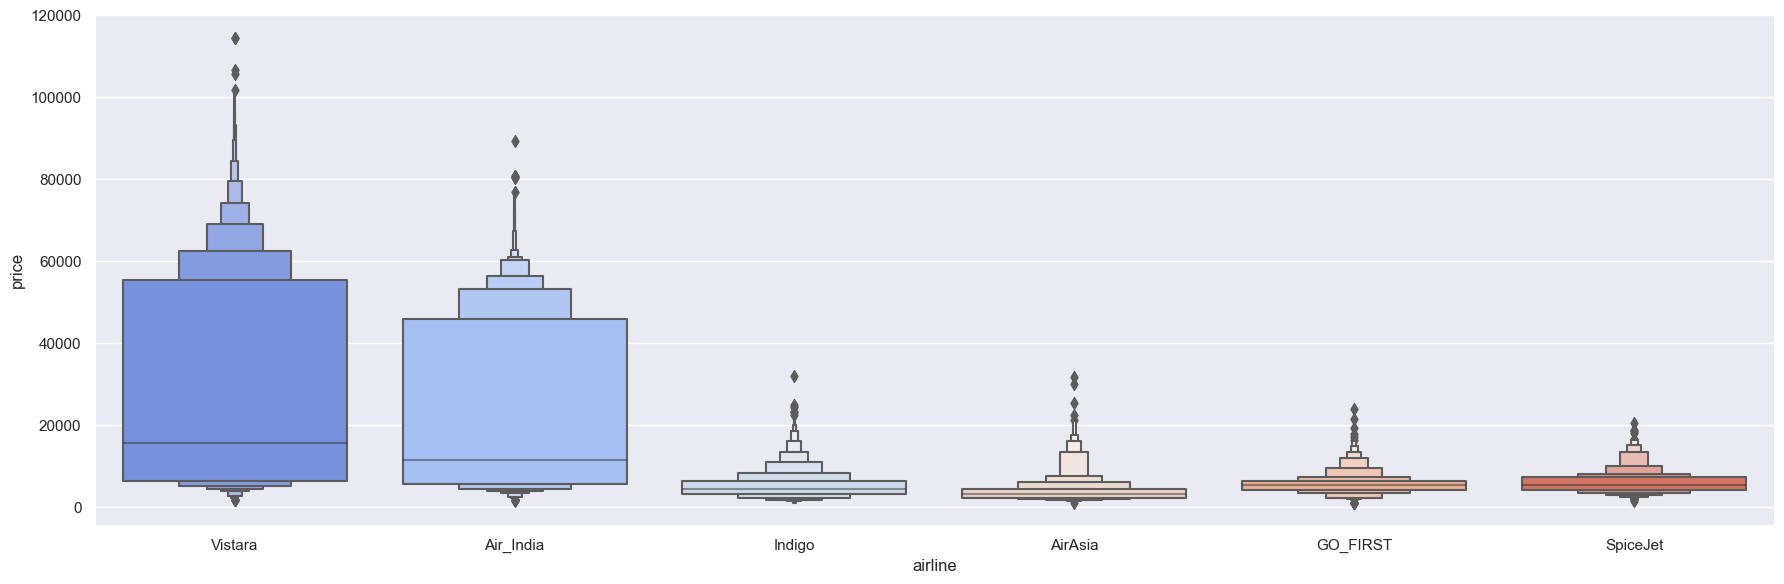

In [349]:
sns.catplot(y="price", x="airline",
            data=train_data.sort_values("price", ascending=False),
            kind="boxen", height = 6, aspect = 3, palette="coolwarm")
plt.show()

In [350]:
Departure = train_data[["departure_time"]]

Departure = pd.get_dummies(Departure, drop_first= True)

Departure.head()

,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night
0,1,0,0,0,0
1,0,1,0,0,0
2,0,0,0,1,0
3,0,0,0,1,0
4,1,0,0,0,0


In [351]:
Arrival = train_data[["arrival_time"]]

Arrival = pd.get_dummies(Arrival, drop_first= True)

Arrival.head()

,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
0,0,0,0,0,1
1,0,0,0,0,1
2,0,1,0,0,0
3,0,1,0,0,0
4,0,0,0,1,0


In [352]:
Airline = train_data[["airline"]]

Airline = pd.get_dummies(Airline, drop_first= True)

Airline.head()

,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,1,0,0


In [353]:
Destination = train_data[["destination_city"]]

Destination = pd.get_dummies(Destination, drop_first = True)

Destination.head()

,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,0,0,0,0,1
1,0,0,0,1,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,0,1


In [354]:
Source = train_data[["source_city"]]

Source = pd.get_dummies(Source, drop_first = True)

Source.head()

,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai
0,0,0,0,0,0
1,0,0,1,0,0
2,0,0,0,0,0
3,0,0,0,1,0
4,1,0,0,0,0


In [355]:
train_data.drop(["flight"], axis = 1, inplace = True)

In [356]:
# Concatenate dataframe --> train_data + Airline + Source + Destination

data_train = pd.concat([train_data, Departure, Arrival, Airline, Source, Destination], axis = 1)


In [357]:
data_train.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,Vistara,Bangalore,Early_Morning,1,Night,Mumbai,0,14.25,21,7212,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,SpiceJet,Hyderabad,Evening,0,Night,Kolkata,0,1.75,7,5292,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
2,Vistara,Bangalore,Morning,1,Evening,Delhi,1,9.58,5,60553,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,Vistara,Kolkata,Morning,1,Evening,Hyderabad,0,6.75,28,5760,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,Indigo,Chennai,Early_Morning,0,Morning,Mumbai,0,2.00,4,10712,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [358]:
data_train.drop(
    [
        "source_city", 
        "destination_city",
        "departure_time",
        "arrival_time",
        "airline",
    ],
    axis = 1, inplace = True

)
data_train.head()

,stops,class,duration,days_left,price,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,1,0,14.25,21,7212,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,1.75,7,5292,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
2,1,1,9.58,5,60553,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,1,0,6.75,28,5760,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,0,0,2.00,4,10712,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


<Axes: >

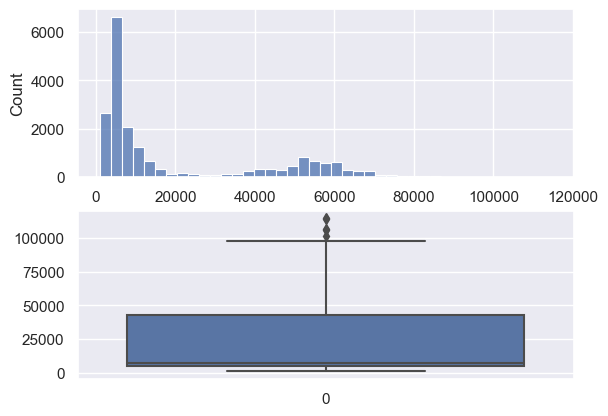

In [359]:
# Checking for outliers
fig,(ax1,ax2)=plt.subplots(2,1)
sns.histplot(data_train['price'],ax=ax1)
sns.boxplot(data_train['price'],ax=ax2)

In [360]:
# #As there is some outliers in price feature,so we replace it with median.
# data_train['price']=np.where(data_train['price']>=70000,data_train['price'].median(),data_train['price'])
# fig,(ax1,ax2)=plt.subplots(2,1)
# sns.histplot(data_train['price'],ax=ax1)
# sns.boxplot(data_train['price'],ax=ax2)

In [361]:
X=data_train.drop('price',axis=1)
y=train_data['price']

In [362]:
X.head()

,stops,class,duration,days_left,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,1,0,14.25,21,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,1.75,7,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
2,1,1,9.58,5,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,1,0,6.75,28,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,0,0,2.00,4,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [363]:
y.head()

0     7212
1     5292
2    60553
3     5760
4    10712
Name: price, dtype: int64

### Feature Selection
Finding out the best feature which will contribute and have good relation with target variable.

In [364]:
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [365]:
imp = pd.DataFrame(selection.feature_importances_,index=X.columns)
imp

,0
stops,0.032749
class,0.879705
duration,0.021338
days_left,0.019543
departure_time_Early_Morning,0.001165
departure_time_Evening,0.001753
departure_time_Late_Night,0.000066
departure_time_Morning,0.001624
departure_time_Night,0.001154
arrival_time_Early_Morning,0.000791


In [366]:
imp.columns=['importance']
imp.sort_values(by='importance',ascending=False)

,importance
class,0.879705
stops,0.032749
duration,0.021338
days_left,0.019543
airline_Air_India,0.005442
airline_Vistara,0.005385
source_city_Delhi,0.004412
destination_city_Delhi,0.003454
source_city_Kolkata,0.002396
source_city_Mumbai,0.002296


In [367]:
X = X.drop([
    "departure_time_Late_Night",
    "airline_SpiceJet",
    "airline_GO_FIRST",
    "airline_Indigo",
    "arrival_time_Late_Night",
    "departure_time_Early_Morning",
    "arrival_time_Morning",
    
], axis=1)

In [368]:
### Test Data
# stops column values changed to numeric
test_data['stops'] = test_data['stops'].replace({"zero": 0, "one": 1, "two_or_more": 2})
test_data['class'] = test_data['class'].replace({"Economy": 0, "Business": 1})

### Handling categorical data
Arrival = test_data[["arrival_time"]]
Arrival = pd.get_dummies(Arrival, drop_first= True)

Source = test_data[["source_city"]]
Source = pd.get_dummies(Source, drop_first = True)

Destination = test_data[["destination_city"]]
Destination = pd.get_dummies(Destination, drop_first = True)

Airline = test_data[["airline"]]
Airline = pd.get_dummies(Airline, drop_first= True)

Departure = test_data[["departure_time"]]
Departure = pd.get_dummies(Departure, drop_first= True)

data_test = pd.concat([test_data, Departure, Arrival, Airline, Source, Destination], axis = 1)

data_test.fillna("median", inplace=True)

test_data = data_test.drop(
    [
        "source_city", 
        "destination_city",
        "departure_time",
        "arrival_time",
        "airline",
        "departure_time_Late_Night",
        "airline_SpiceJet",
        "airline_GO_FIRST",
        "airline_Indigo",
        "arrival_time_Late_Night",
        "departure_time_Early_Morning",
        "arrival_time_Morning",
        "id",
        "flight"
    ],
    axis = 1
)

In [369]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [370]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [371]:
y_pred = reg_rf.predict(X_test)

In [372]:
reg_rf.score(X_train, y_train)

0.9956474019667791

In [373]:
reg_rf.score(X_test, y_test)

0.9715828899950663

/tmp/ipykernel_78973/3453123835.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


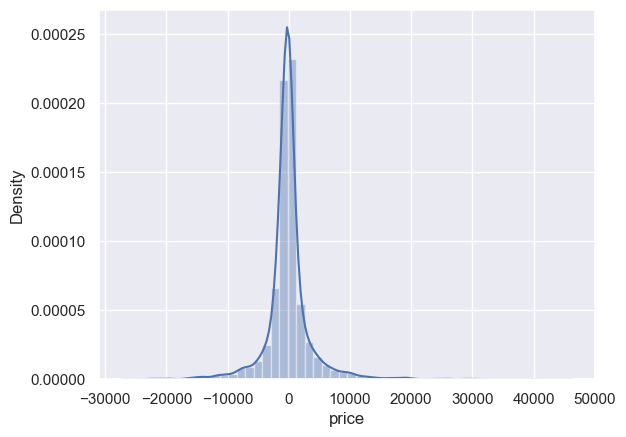

In [374]:
sns.distplot(y_test-y_pred)
plt.show()

In [375]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 2082.139476455357
MSE: 14922276.914453607
RMSE: 3862.936307325505


In [376]:
metrics.r2_score(y_test, y_pred)

0.9715828899950663

In [377]:
from sklearn.neighbors import KNeighborsRegressor
reg_kn = KNeighborsRegressor()
reg_kn.fit(X_train, y_train)

KNeighborsRegressor()

In [378]:
y_pred = reg_kn.predict(X_test)

In [379]:
metrics.r2_score(y_test, y_pred)

0.6104971567972945

In [380]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 9865.2788
MSE: 204534144.5428
RMSE: 14301.543432189408


In [381]:
from sklearn.tree import DecisionTreeRegressor
ds_tree = DecisionTreeRegressor()
ds_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [382]:
y_pred = ds_tree.predict(X_test)

In [383]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 2462.381375
MSE: 26838095.6564375
RMSE: 5180.549744615671


In [384]:
from sklearn.ensemble import GradientBoostingRegressor
gr_b = GradientBoostingRegressor()
gr_b.fit(X_train, y_train)

GradientBoostingRegressor()

In [385]:
y_pred = gr_b.predict(X_test)

In [386]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 2978.1961697197435
MSE: 24938992.04159359
RMSE: 4993.895477640034


In [387]:
y_pred = reg_rf.predict(test_data)

In [392]:
submission = load_flight_price_data("./", "sample_solution.csv")
submission['price']=y_pred

submission.to_csv('submission.csv', index=False)

In [394]:
pd.read_csv('submission.csv')

,id,price
0,1,52546.04
1,2,58532.54
2,3,23062.06
3,4,4177.16
4,5,5606.90
...,...,...
4995,4996,59373.65
4996,4997,4479.94
4997,4998,50160.04
4998,4999,48901.50
